# DeePC Implementation

## Packages

In [13]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

%matplotlib inline
%reload_ext autoreload
%autoreload 

from controllers import DeePC

## Recht system

In [14]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix

n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                           


## Data Collection

ud shape : (67, 3), yd shape : (67, 3)


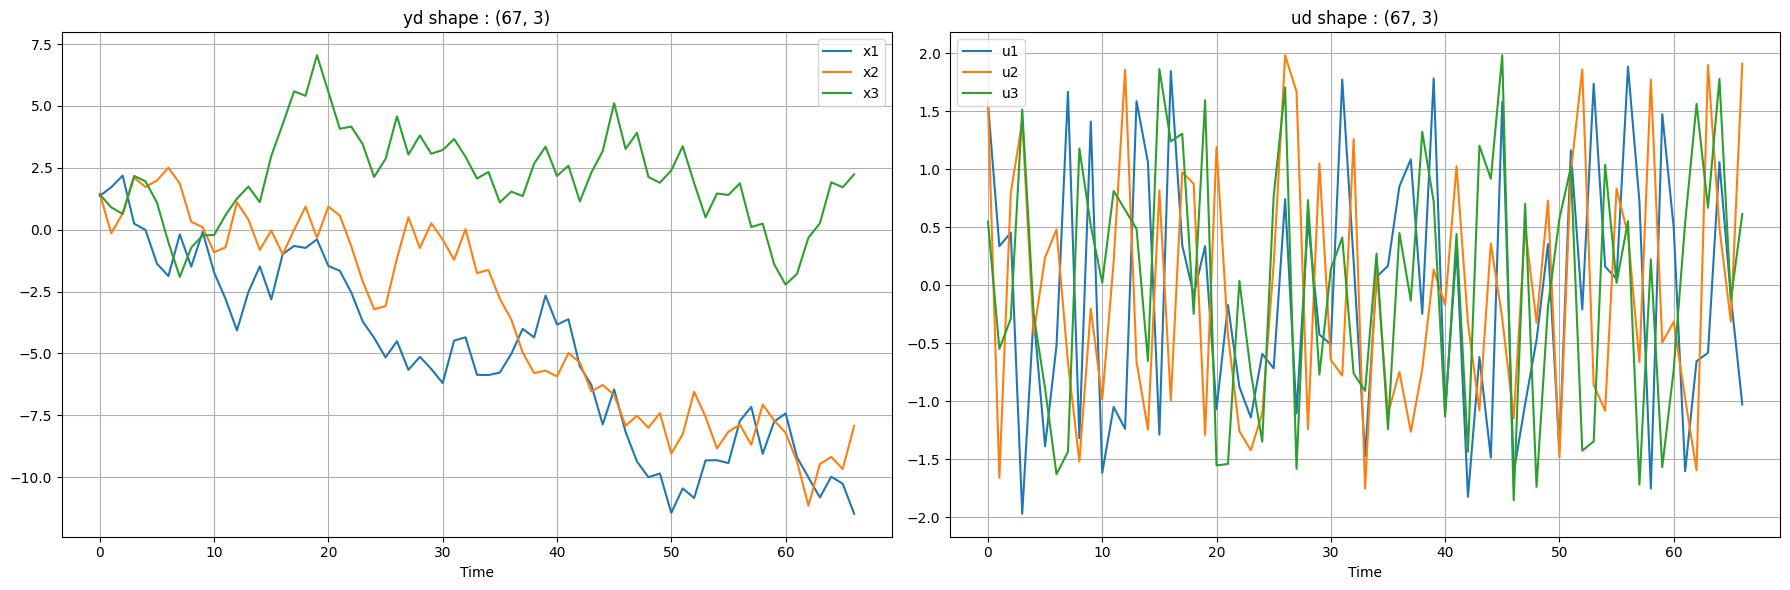

In [15]:
ud = []
yd = []
x = np.random.uniform(low=-2, high=2, size=(m,)) # Random initial condition
for i in range(T):
   u = np.random.uniform(low=-2, high=2, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y + np.random.randn(p,)*0.01) 
ud = np.array(ud)
yd = np.array(yd)

print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid(True)
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

## Controller Setup

In [16]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([4,4,4]))
u_constraonts = np.kron(np.ones(Tf), np.array([2,2,2]))
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)

## Simulation

In [17]:
T = 30
dt = 0.1
uT = [*u_ini]
yT = [*y_ini]

for i in range(0,T):

    # Time varying reference -> 3 sinusoids, 120 degrees phase shift
    r = np.array([
        [4*np.sin(t/3), 4*np.sin(t/3 - np.pi*0.66), 4*np.sin(t/3 - 2*np.pi*0.66)] for t in np.linspace(start=i, stop=i+1, num=Tf)
    ])
    r = r.reshape((Tf*3,))
    
    # Solve for optimal input
    controller.setup(ref=r, u_ini=u_ini, y_ini=y_ini, lam_y=0.7)
    action = controller.solve(verbose=False)

    # roll forward simulation and reset initial conditions
    obs = A@y_ini[-p:] + action
    yT = np.append(yT, obs + np.random.randn(p,)*0.01)
    uT = np.append(uT, action)
    u_ini = uT[-m*Tini:]
    y_ini = yT[-p*Tini:]

## Visualisation

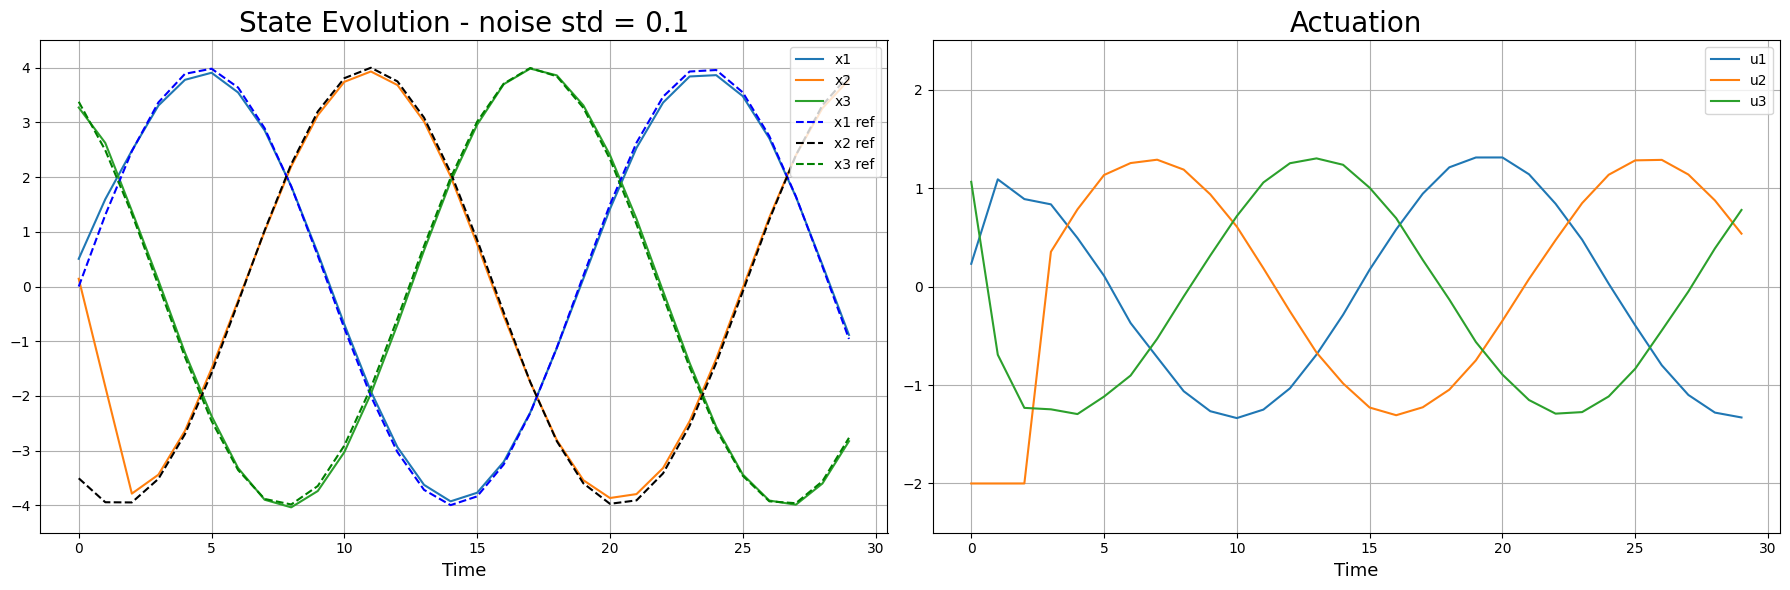

In [18]:
plt.rcParams["figure.figsize"] = (18,6)
yT, uT = np.array(yT), np.array(uT)

# For plotting purposes
ref = np.array([
    [4*np.sin(t/3), 4*np.sin(t/3 - np.pi*0.66), 4*np.sin(t/3 - 2*np.pi*0.66)] for t in np.linspace(start=0, stop=T-1, num=int(Tf*T*dt))
])

yT = yT.reshape((T+Tini,3))
uT = uT.reshape((T+Tini,3))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT[Tini:,:], label=['x1', 'x2', 'x3'])
plt.plot(range(0,T), ref[:,0], 'b--', label='x1 ref')
plt.plot(range(0,T), ref[:,1], 'k--', label='x2 ref')
plt.plot(range(0,T), ref[:,2], 'g--', label='x3 ref')
plt.legend(loc="upper right")
plt.xlabel('Time', fontdict={'fontsize':13})
plt.title(f"State Evolution - noise std = 0.1", fontdict={'fontsize':20})
plt.grid('on')
plt.ylim(-4.5,4.5)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT[Tini:,:], label=['u1', 'u2', 'u3'])
plt.legend(loc="upper right")
plt.xlabel('Time', fontdict={'fontsize':13})
plt.title("Actuation", fontdict={'fontsize':20})
plt.grid('on')
plt.ylim(-2.5,2.5)
plt.tight_layout()

plt.show()